In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import glob
from sunpy import timeseries as ts
import datetime
from sunpy.net import Fido, attrs as a 

In [4]:
flare_list = pd.read_csv("/Users/laurahayes/ml_project_flares/flare_analysis/goes_flare_list/final_flare_list.csv")
flare_list["event_starttime"] = pd.to_datetime(flare_list["event_starttime"])
flare_list["event_endtime"] = pd.to_datetime(flare_list["event_endtime"])
flare_list["tt"] = [x.total_seconds() for x in flare_list.event_starttime - flare_list.event_starttime[0]]

# for flares in which cross midnight to next day
flare_list.loc[(pd.to_datetime(flare_list.event_endtime)<flare_list.event_starttime),'event_endtime']=pd.to_datetime(flare_list["event_endtime"]) + datetime.timedelta(days=1)
flare_list.loc[(pd.to_datetime(flare_list.event_peaktime)<flare_list.event_starttime),'event_peaktime']=pd.to_datetime(flare_list["event_peaktime"]) + datetime.timedelta(days=1)

# drop duplicate records
flare_list = flare_list.drop_duplicates(subset="event_peaktime")

#tidy up AR numbers
flare_list["noaa_ar"] = flare_list["noaa_ar"].replace(["\n","", "     "], 0)
flare_list["noaa_ar"] = flare_list["noaa_ar"].astype(int)

# add column to match with AR data
flare_list["matchtime"] = flare_list["event_starttime"].dt.strftime("%Y-%m-%d 00:30")

# fix integrated flux
flare_list["integrated_flux"] = flare_list["integrated_flux"].replace(['',"", "       "], 0).astype(float)

flare_list.reset_index(inplace=True, drop=True)

In [5]:
# flare_list = flare_list[flare_list["goes_class_val"] >=5e-6]

In [6]:
data_dir = '/Users/laurahayes/QPP/stats_study/TEBBS/goes_rawdata/'

In [7]:
files = list(flare_list["event_starttime"].dt.strftime("*%Y%m%d.fits"))

In [8]:
file = glob.glob(data_dir+flare_list.iloc[1000]["event_starttime"].strftime("*%Y%m%d.fits")); file

['/Users/laurahayes/QPP/stats_study/TEBBS/goes_rawdata/go1520110924.fits']

In [11]:
def checks():
    all_files = []
    for i in range(len(files)):
        all_files.append(glob.glob(data_dir + files[i]))
    leny = [len(x) for x in all_files]
    np.where(np.array(leny)<1)

# Lets try read in the lightcurves and calc FWHM

In [12]:
def get_fwhm(flare_list, i):
    tstart = flare_list.iloc[i]["event_starttime"]
    tend = flare_list.iloc[i]["event_endtime"]

    file_s = tstart.strftime("*%Y%m%d.fits")
    file_e = tend.strftime("*%Y%m%d.fits")


    if file_s == file_e:
        goes = ts.TimeSeries(data_dir + file_s)
    else:
        goes = ts.TimeSeries(data_dir + file_s, data_dir + file_e, concatenate=True)


    goes_flare = goes.truncate(tstart-datetime.timedelta(minutes=5), tend+datetime.timedelta(minutes=20))

    gl = goes_flare.to_dataframe()["xrsb"]
    gs = goes_flare.to_dataframe()["xrsa"]

    peak_half = gl[0] + (np.max(gl) - gl[0])/2 
    
    fwhm = gl[gl > peak_half]
    fwhm_s = min(fwhm.index)
    fwhm_e = max(fwhm.index)

    fwhm_seconds = (fwhm_e - fwhm_s).total_seconds()
    return fwhm_seconds

In [14]:
flare_xm = flare_list[flare_list["goes_class_ind"].isin(["X", "M"])]
flare_xm.reset_index(inplace=True, drop=True)

In [18]:
errors = []
fwhm_list = []
for i in range(len(flare_xm)):
    print(i)
    try:
        fwhm = get_fwhm(flare_xm, i)
        fwhm_list.append(fwhm)
    except:
        print("error", i)
        fwhm_list.append(np.nan)
        errors.append(i)
        
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
error 32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
error 265
266
error 266
267
error 267

In [23]:
flare_xm["fwhm"] = fwhm_list

<ipython-input-23-57341e7d11da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flare_xm["fwhm"] = fwhm_list


In [24]:
flare_xm["dur_peak"] = [x.total_seconds() for x in pd.to_datetime(flare_xm["event_peaktime"]) - pd.to_datetime(flare_xm["event_starttime"])]
flare_xm["dur_full"] = [x.total_seconds() for x in pd.to_datetime(flare_xm["event_endtime"]) - pd.to_datetime(flare_xm["event_starttime"])]



<ipython-input-24-23bfa782f60d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flare_xm["dur_peak"] = [x.total_seconds() for x in pd.to_datetime(flare_xm["event_peaktime"]) - pd.to_datetime(flare_xm["event_starttime"])]
<ipython-input-24-23bfa782f60d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flare_xm["dur_full"] = [x.total_seconds() for x in pd.to_datetime(flare_xm["event_endtime"]) - pd.to_datetime(flare_xm["event_starttime"])]


/Users/laurahayes/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


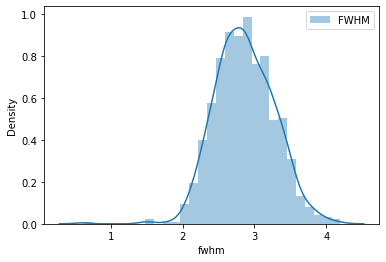

In [34]:
import seaborn as sns
sns.distplot(np.log10(flare_xm["fwhm"]), label="FWHM")
#sns.distplot(np.log10(flare_xm["dur_full"]), label="Full")
plt.legend()

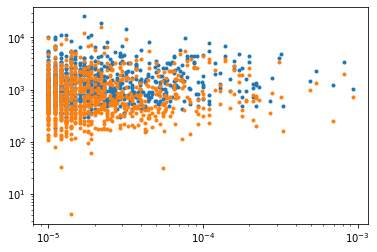

In [38]:
plt.loglog(flare_xm["goes_class_val"], flare_xm["dur_full"], marker='.', ls='')
plt.loglog(flare_xm["goes_class_val"], flare_xm["fwhm"], marker='.', ls='')

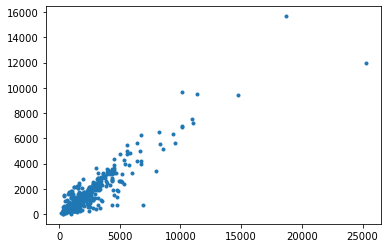

In [41]:
plt.plot(flare_xm["dur_full"], flare_xm["fwhm"], marker='.', ls='')

In [30]:
flare_x = flare_xm[flare_xm["goes_class_ind"].isin(["X"])]
flare_m = flare_xm[flare_xm["goes_class_ind"].isin(["M"])]

/Users/laurahayes/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/laurahayes/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


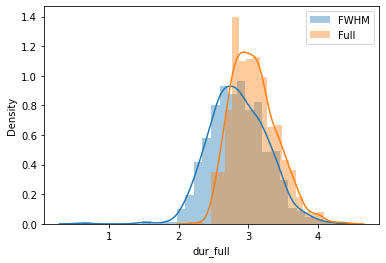

In [33]:
sns.distplot(np.log10(flare_m["fwhm"]), label="FWHM")
sns.distplot(np.log10(flare_m["dur_full"]), label="Full")
plt.legend()

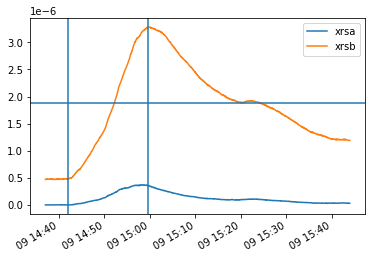

In [94]:
goes_flare.plot()
plt.axvline(gl.index[np.argmax(gl)])
plt.axvline(tstart)

peak_half = gl[0] + (np.max(gl) - gl[0])/2
plt.axhline(peak_half)

In [106]:
fwhm = gl[gl > peak_half]
fwhm_s = min(fwhm.index)
fwhm_e = max(fwhm.index)

total_seconds = (fwhm_e - fwhm_s).total_seconds()

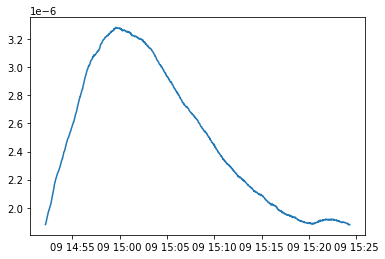

In [107]:
plt.plot(fwhm)

In [100]:
test

2011-09-09 14:37:00.721999884   -1.406040e-06
2011-09-09 14:37:02.768999934   -1.406040e-06
2011-09-09 14:37:04.818999887   -1.403420e-06
2011-09-09 14:37:06.864999890   -1.403420e-06
2011-09-09 14:37:08.914999962   -1.408660e-06
                                     ...     
2011-09-09 15:43:50.634999871   -6.872600e-07
2011-09-09 15:43:52.681999922   -6.872600e-07
2011-09-09 15:43:54.731999874   -6.898600e-07
2011-09-09 15:43:56.778999925   -6.872600e-07
2011-09-09 15:43:58.828999877   -6.872600e-07
Name: xrsb, Length: 1963, dtype: float32

In [17]:
def get_goes_file(tstart, tend, savedir=data_dir):
    res = Fido.search(a.Time(tstart, tend), 
                      a.Instrument("XRS"), a.Provider.sdac)
    if res.file_num>1:
        if len(res[0][res[0]["SatelliteNumber"]==15]) ==1:
            Fido.fetch(res[0][res[0]["SatelliteNumber"]==15], path=savedir)
        else:
            Fido.fetch(res[0, 0], path=savedir)
    elif res.file_num==1:
        Fido.fetch(res, path=savedir)
    else:
        print("no files found")

In [19]:
def get_all_data():
    for i in range(len(flare_list)):
        file = glob.glob(data_dir+flare_list.iloc[i]["event_starttime"].strftime("*%Y%m%d.fits"))
        if len(file)==0:
            get_goes_file(flare_list.iloc[i]["event_starttime"], flare_list.iloc[i]["event_endtime"])

In [104]:
flare_list

,index,event_starttime,event_peaktime,event_endtime,goes_class_ind,goes_class,goes_class_val,integrated_flux,noaa_ar,position_hgs,hgs_lat,hgs_lon,hpc_x,hpc_y,tt,matchtime
0,10,2010-01-19 08:34:00,2010-01-19 08:45:00,2010-01-19 09:14:00,C,C5.2,0.000005,0.0092,11040,N28W86,28.0,86.0,858.737891,461.190787,1473900.0,2010-01-19 00:30
1,12,2010-01-19 13:03:00,2010-01-19 13:41:00,2010-01-19 13:50:00,M,M2.3,0.000023,0.0390,11041,S25E88,-25.0,-88.0,-883.257005,-407.884961,1490040.0,2010-01-19 00:30
2,14,2010-01-19 17:44:00,2010-01-19 17:55:00,2010-01-19 18:21:00,C,C5.1,0.000005,0.0084,11041,S25E87,-25.0,-87.0,-882.637199,-406.545432,1506900.0,2010-01-19 00:30
3,15,2010-01-19 20:23:00,2010-01-19 20:35:00,2010-01-19 20:46:00,M,M1.7,0.000017,0.0180,11041,S25E88,-25.0,-88.0,-883.237075,-407.842571,1516440.0,2010-01-19 00:30
4,20,2010-01-20 04:48:00,2010-01-20 04:57:00,2010-01-20 05:03:00,C,C5.0,0.000005,0.0026,11041,S25E88,-25.0,-88.0,-883.213777,-407.793814,1546740.0,2010-01-20 00:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771,8581,2017-09-09 22:04:00,2017-09-09 23:53:00,2017-09-10 00:41:00,M,M1.1,0.000011,0.0690,12673,S09W88,-9.0,88.0,940.315699,-151.974097,242578500.0,2017-09-09 00:30
1772,8582,2017-09-10 02:40:00,2017-09-10 03:09:00,2017-09-10 03:25:00,C,C9.0,0.000009,0.0150,12673,S09W88,-9.0,88.0,940.361147,-151.981292,242595060.0,2017-09-10 00:30
1773,8586,2017-09-10 15:35:00,2017-09-10 16:06:00,2017-09-10 16:31:00,X,X8.2,0.000820,1.4000,12673,S08W88,-8.0,88.0,942.955286,-135.698622,242641560.0,2017-09-10 00:30
1774,8592,2017-10-20 23:10:00,2017-10-20 23:28:00,2017-10-20 23:37:00,M,M1.1,0.000011,0.0088,12685,S12E88,-12.0,-88.0,-941.934337,-202.542692,246124860.0,2017-10-20 00:30
